In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal
import os
import inspect

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [3]:
from pyha.cores import Spectrogram
from pyha.cores.util import *
plt.rcParams['figure.figsize'] = 15, 5

In [4]:
fft_size = 1024

In [5]:
from pyha.cores import BitreversalFFTshiftAVGPool
file = os.path.dirname(inspect.getfile(BitreversalFFTshiftAVGPool)) + '/phantom3_low_power_bladerf.npy'
orig_inp = np.load(file) # IQ samples
orig_inp = orig_inp[:int(len(orig_inp)/fft_size)*fft_size][:fft_size*1]
# orig_inp *= 128

In [53]:
print(sims['MODEL'].shape)

(2, 128)


In [57]:
print(np.array(sims['PYHA']).shape)

(2, 128)


INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1024/1024 [00:00<00:00, 1707.79it/s]

INFO:sim:OK!


INFO:sim:Simulations completed!


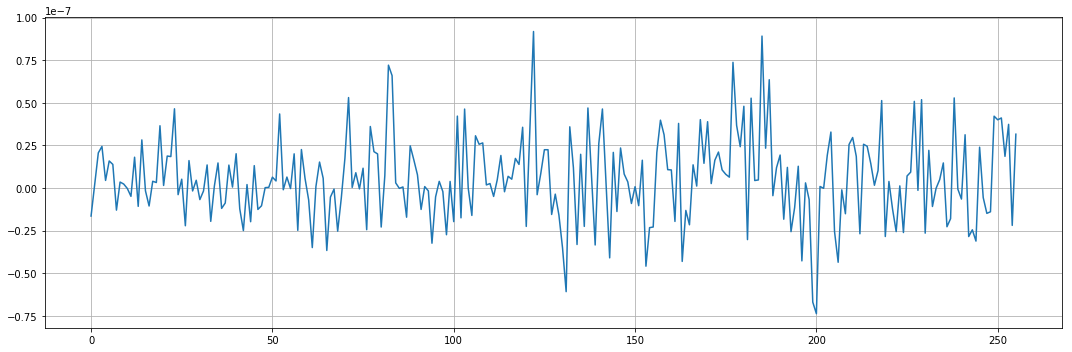

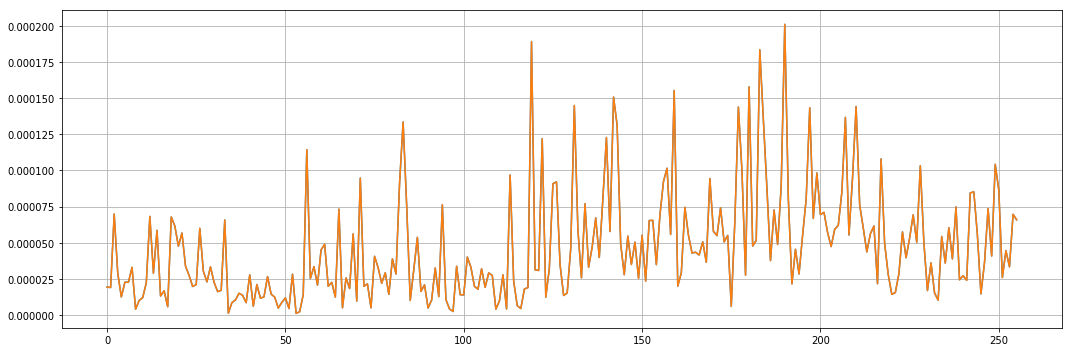

In [59]:
np.random.seed(0)
input_power = 0.25
fft_size=256
input_size = (4) * fft_size
orig_inp = (np.random.uniform(-1, 1, size=input_size) + np.random.uniform(-1, 1, size=input_size) * 1j) * input_power
dut = Spectrogram(fft_size, 2, 2)

orig_inp_quant = np.vectorize(lambda x: complex(Complex(x, 0, -17)))(orig_inp)
sims = simulate(dut, orig_inp_quant, simulations=['MODEL', 'PYHA'])

# assert sims_close(sims, rtol=1e-6, atol=1e-6)


plt.plot(sims['MODEL'].flatten() - sims['PYHA'].flatten())
show_plot()

plt.plot(sims['MODEL'].flatten())
plt.plot(sims['PYHA'].flatten())
show_plot()

## Spectrogram

In [12]:
from pyha.cores import DCRemoval
dut = DCRemoval(window_len=256, dtype=Complex)
sims = simulate(dut, orig_inp, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1029/1029 [00:00<00:00, 7942.57it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


SNR: 44.39
(1024,)


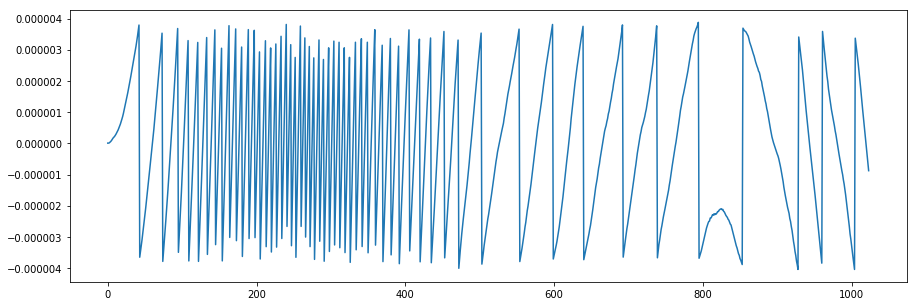

In [13]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA']):.2f}")
plt.plot(sims['MODEL'] - sims['PYHA'])
print(sims['MODEL'].shape)

In [14]:
dut = Spectrogram(fft_size, avg_freq_axis=2, avg_time_axis=1)
sims = simulate(dut, orig_inp, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1031/1031 [00:00<00:00, 5298.21it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


SNR: 44.39
(1024,)


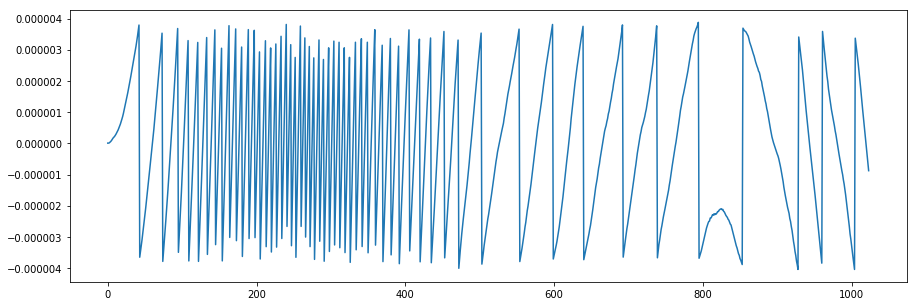

In [15]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA']):.2f}")
plt.plot(sims['MODEL'] - sims['PYHA'])
print(sims['MODEL'].shape)

## Use `avg_freq_axis` and  `avg_time_axis` to control average pooling

In [10]:
dut = Spectrogram(fft_size, avg_freq_axis=8, avg_time_axis=4)
sims = simulate(dut, orig_inp, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1031/1031 [00:00<00:00, 5548.14it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [11]:
print(f"SNR: {snr(sims['MODEL'], sims['PYHA']):.2f}")
imshow(sims['PYHA'].T)

SNR: 44.39


TypeError: cannot unpack non-iterable type object

# Limitations

## Fixed-point
Expects standard FPGA Fixed point format i.e 18 bits (incl. sign) and scaled to -1...1 range.

In [ ]:
print(f'Minimum number representabe: {2**-17}')

## Average pooling cannot be turned off i.e. setting `avg_freq_axis=1, avg_time_axis=1`
For this case the implementation could be simplified i.e. no need for high-precision fixed-point and read-modify-write.

# Synthesis
`avg_freq_axis` controls the memory usage and decimates the output data rate.

`avg_time_axis` decimates output data rate but has ~no effect on resource usage.

## `avg_freq_axis=8` and `avg_time_axis=4`

In [ ]:
dut = Spectrogram(fft_size, avg_freq_axis=8, avg_time_axis=4)
sims = simulate(dut, orig_inp[:4*fft_size], simulations=['PYHA', 'RTL', 'GATE'])

In [ ]:
assert sims_close(sims, rtol=1e-10, atol=1e-10)

In [ ]:
lut, mem, mul = get_resource_usage()
print(f'Logic elements: {lut}')
print(f'Memory: {mem}')
print(f'Multipler (18bit): {mul//2}')